In [92]:
import pyemd
from choquet_integral import *
import random
import numpy as np
import xai_indices as xai
from matplotlib import cm
from scipy.spatial import distance

In [11]:
def random_node_fm(n):
    ch = ChoquetIntegral()
    ch.type='quad'
    ch.fm = {}
    ch.fm[str(np.arange(1,n+1))] = 1
    ch.fm['[]'] = 0
    ch.N = n
    ch.M = n
    numkeys = len(ch.get_keys_index())
    keys = list(ch.get_keys_index().keys())
    keys.append('[]')
    s = [0] * (numkeys + 1)
    s[-1] = 1
    s[-2] = 1
    done = False
    while not done:
        randindex = random.randrange(0,numkeys)
        if s[randindex] == 0:
            s[randindex] = 1
            if keys[randindex] != '[]':
                compare_key = [int(s) for s in keys[randindex][1:-1].split() if s.isdigit()]

            else:
                compare_key = []

            maxi = 0
            max_index = 0
            mini = 1
            min_index = 0
            for i,key in enumerate(keys):
                if s[i] == 1 and i != randindex:
                    if key != '[]':
                        stripped = [int(s) for s in key[1:-1].split() if s.isdigit()]
                    else:
                        stripped = []

                    if is_subset(stripped,compare_key) and s[i] == 1 and ch.fm[key] >= maxi:
                        maxi = ch.fm[key]
                        max_index = i
                    if is_subset(compare_key,stripped) and s[i] == 1 and ch.fm[key] <= mini:

                        mini = ch.fm[key]
                        min_index = i


            rb = ch.fm[keys[max_index]]
            ru = ch.fm[keys[min_index]]
            g = random.uniform(rb,ru)
            ch.fm[keys[randindex]] = g

        else:
            pass
        if min(s) == 1:
            done = True
    return ch

def is_subset(a,b):
    if len(a) == 0:
        return True
    if len(b) == 0 and len(a) != 0:
        return False
    for val in a:
        if val not in b:
            return False
    else:
        return True
    
def gen_unit_distance_matrix(n):
    distance_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            distance_matrix[i][j] = np.abs(i-j)
    return distance_matrix 

def gen_datapoints(m,n):
    points = []
    for i in range(n):
        point = []
        for j in range(m):
            point.append(random.random())
        points.append(point)
    return np.asarray(points)

def sample_with_noise(ch,data,mean,var):
    labels = np.zeros(data.shape[0])
    for i,point in enumerate(data):
        labels[i] = max(min(ch.chi_quad(point) + random.gauss(mean,var),1),0)
    return labels

def percentage_walks_observed(walks):
    seen = 0
    total = 0
    for key in walks.keys():
        if walks[key] > 0:
            seen = seen + 1
        total = total+1
    return seen/total

In [12]:
fm1 = random_node_fm(5)
fm2 = random_node_fm(5)
walk_diffs1 = fm1.generate_walk_diffs()
walk_diffs2 = fm2.generate_walk_diffs()



In [13]:
def fm_emd_diff(ch1,ch2):
    fm1 = ch1.generate_walk_diffs()
    fm2 = ch2.generate_walk_diffs()

    total_diff = 0
    dist_mat = gen_unit_distance_matrix(5)
    for i in range(len(fm1)):
        total_diff += pyemd.emd(fm1[i],fm2[i],dist_mat)

    total_diff /= len(walk_diffs1)
    return total_diff

def data_emd_diff(ch1,ch2,walks1,walks2):
    fm1 = ch1.generate_walk_diffs()
    fm2 = ch2.generate_walk_diffs()
    
    walk1_total = 0
    walk2_total = 0
    for i in range(len(list(walks1.values()))):
        walk1_total += list(walks1.values())[i]
        walk2_total += list(walks2.values())[i]
    print(walk1_total)
    print(walk2_total)
    
    total_diff = 0
    dist_mat = gen_unit_distance_matrix(5)
    for i in range(len(fm1)):
        total_diff += pyemd.emd(fm1[i],fm2[i],dist_mat) * ((list(walks1.values())[i]/walk1_total + list(walks2.values())[i]/walk2_total))
        
    total_diff /= 2
    return total_diff

In [14]:
data = gen_datapoints(5,300)
data2 = gen_datapoints(5,300)
noisy_labels = sample_with_noise(fm1,data,0,0)
noisy_labels2 = sample_with_noise(fm2,data2,0,0)

ch1 = ChoquetIntegral()
ch1.train_chi(data.T,noisy_labels)

ch2 = ChoquetIntegral()
ch2.train_chi(data2.T,noisy_labels2)

(walks1,_) = xai.walk_visitation(data.T)
(walks2,_) = xai.walk_visitation(data2.T)
# print(walks)
# print(percentage_walks_observed(walks))
# print(percentage_walks_observed(walks2))
diff = fm_emd_diff(ch1,ch2)
weighted_diff = data_emd_diff(ch1,ch2,walks1,walks2)

print("reg",diff)
print("weighted",weighted_diff)


Number Inputs :  5 ; Number Samples :  300
     pcost       dcost       gap    pres   dres
 0: -4.8195e+01 -6.5792e+01  1e+02  9e+00  4e-01
 1: -4.7037e+01 -6.7898e+01  4e+01  2e+00  7e-02
 2: -4.7839e+01 -5.4168e+01  7e+00  1e-01  5e-03
 3: -4.8528e+01 -4.9625e+01  1e+00  1e-02  5e-04
 4: -4.8669e+01 -4.9047e+01  4e-01  3e-03  1e-04
 5: -4.8735e+01 -4.8852e+01  1e-01  5e-05  2e-06
 6: -4.8747e+01 -4.8771e+01  2e-02  5e-07  2e-08
 7: -4.8749e+01 -4.8751e+01  2e-03  2e-08  9e-10
 8: -4.8749e+01 -4.8749e+01  1e-04  7e-10  3e-11
 9: -4.8749e+01 -4.8749e+01  9e-06  2e-11  8e-13
Optimal solution found.
Number Inputs :  5 ; Number Samples :  300
     pcost       dcost       gap    pres   dres
 0: -1.1660e+02 -1.3355e+02  1e+02  9e+00  2e-01
 1: -1.1640e+02 -1.3362e+02  3e+01  2e+00  4e-02
 2: -1.1682e+02 -1.2137e+02  5e+00  2e-02  4e-04
 3: -1.1718e+02 -1.1822e+02  1e+00  3e-03  7e-05
 4: -1.1729e+02 -1.1741e+02  1e-01  3e-05  7e-07
 5: -1.1730e+02 -1.1733e+02  3e-02  6e-06  1e-07
 6: -1.173

In [81]:
viridis = cm.get_cmap('plasma')

# gen_unit_distance_matrix(2)

In [85]:
def all_lcs(d,inc):
    return_list = []
    expand_list = []
    started = False
    
    while len(expand_list) > 0 or not started:
        if started == False:
            current_lcs = []
            started = True
        else:
            current_lcs = expand_list.pop(0)
            
        if sum(current_lcs) >= 1:
            while(len(current_lcs) < d):
                current_lcs.append(0)
            return_list.append(current_lcs)
        else:
            expand_list.extend(recurse_lcs(d,inc,current_lcs))
            

    return return_list
        
        
        
def recurse_lcs(d,inc,current_lcs):
    return_list = []
    if np.sum(current_lcs) >= 1:
        while(len(current_lcs) < d):
            current_lcs.append(0)
        
        return current_lcs
    
    if len(current_lcs) < d - 1:
        for i in range(int(1.0/inc) + 1):
            if np.sum(current_lcs) + (i*inc) <= 1:
                new_lcs = current_lcs.copy()
                new_lcs.append(i*inc)
                return_list.append(new_lcs)
    
    elif len(current_lcs) == d - 1:
        new_lcs = current_lcs.copy()
        new_lcs.append(1 - np.sum(new_lcs))
        return_list.append(new_lcs)
        
    return return_list


lcs_list = all_lcs(3,.02)

# recurse_lcs(3,.1,[])

In [72]:
viridis(.5)

(0.127568, 0.566949, 0.550556, 1.0)

<IPython.core.display.Javascript object>


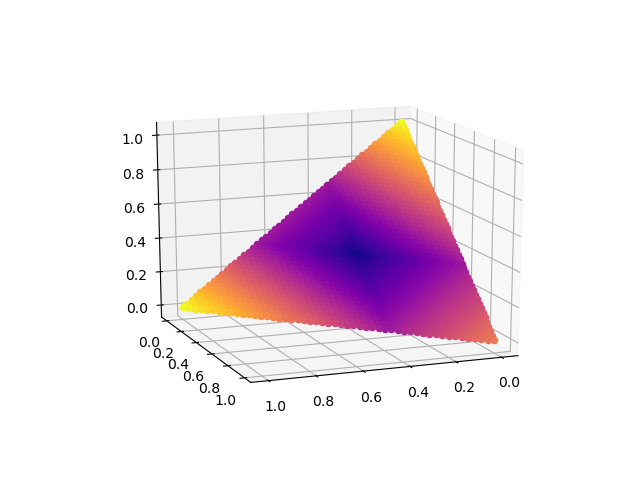

In [112]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for lcs in lcs_list:
    [x,y,z] = lcs
    dist = pyemd.emd(np.asarray(lcs),np.asarray([1/3,1/3,1/3],dtype=float),gen_unit_distance_matrix(3))
    (r,g,b,a) = viridis(dist)
    ax.scatter(x,y,z, c=np.asarray([r,g,b]).reshape(1,-1))

<IPython.core.display.Javascript object>


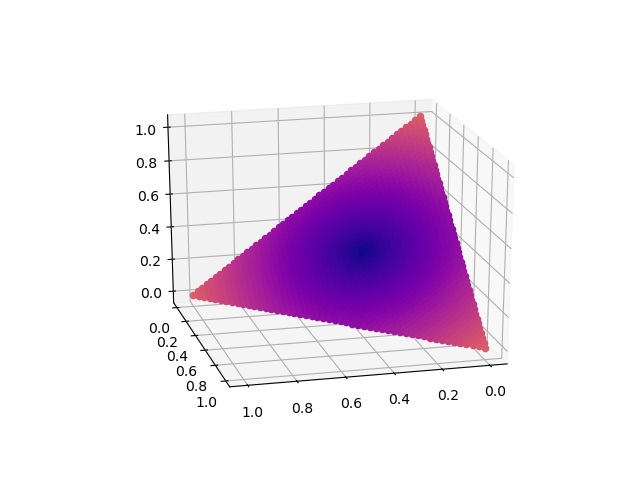

In [110]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


for lcs in lcs_list:
    [x,y,z] = lcs
    dist = distance.euclidean(lcs,np.asarray([1/3,1/3,1/3])) / np.sqrt(2)
    (r,g,b,a) = viridis(dist)
    ax.scatter(x,y,z, c=np.asarray([r,g,b]).reshape(1,-1))

In [108]:
distance.euclidean([1,0,0],[0,0,1])

1.4142135623730951